In [7]:
import pandas as pd
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk

stop_word = StopWordRemoverFactory().create_stop_word_remover()
stemmer = StemmerFactory().create_stemmer()
remove_tanda_baca = nltk.RegexpTokenizer(r"\w+")

def pre_process_text(text):
    text = ' '.join(remove_tanda_baca.tokenize(text))
    return stop_word.remove(stemmer.stem(text))

# Fungsi untuk mengganti nilai rating
def convert_rating(rating):
    if rating >= 3:
        return 1
    elif rating < 3:
        return 0
    else:
        return 0


df = pd.read_csv('./reviews_mandiri.csv')

rating_positif = df[df['rating'] >= 3].sample(n=10000, axis=0)
rating_negatif = df[df['rating'] < 3].sample(n=10000, axis=0)

slice_df = pd.concat([rating_positif, rating_negatif])
slice_df['is_positive'] = slice_df['rating'].apply(convert_rating)
slice_df['review'] = slice_df['review'].apply(pre_process_text)

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

attribute = slice_df['review'].values
label = slice_df['is_positive'].values

data_latih, data_test, label_latih, label_test = train_test_split(attribute,label,test_size=0.2)
tokenizer = Tokenizer(num_words=35000,oov_token='x')
tokenizer.fit_on_texts(data_latih)

sekuens_latih = tokenizer.texts_to_sequences(data_latih)
sekuens_test = tokenizer.texts_to_sequences(data_test)

pad_latih = pad_sequences(sekuens_latih,padding='post',maxlen=87)
pad_test = pad_sequences(sekuens_test,padding='post',maxlen=87)

In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

# Contoh model dasar
model_base = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=15000, output_dim=1, input_length=87),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Model dasar dengan penyetelan hyperparameter
model_base.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop_callback = EarlyStopping(
    monitor='val_accuracy',  # Metrik yang akan dipantau (misalnya, akurasi pada data validasi)
    patience=10,  # Jumlah epoch yang akan ditunggu tanpa peningkatan sebelum pelatihan dihentikan
    restore_best_weights=True  # Mengembalikan bobot model ke bobot terbaik yang ditemukan selama pelatihan
)
training = model_base.fit(
    pad_latih,
    label_latih,
    epochs=50,
    validation_data=(pad_test, label_test),
    callbacks=[early_stop_callback]
)

Epoch 1/50
500/500 [==============================] - 7s 14ms/step - loss: 0.7275 - accuracy: 0.5004 - val_loss: 0.6951 - val_accuracy: 0.4930
Epoch 2/50
500/500 [==============================] - 7s 14ms/step - loss: 0.7230 - accuracy: 0.4992 - val_loss: 0.6956 - val_accuracy: 0.5070
Epoch 3/50
500/500 [==============================] - 7s 13ms/step - loss: 0.7162 - accuracy: 0.4964 - val_loss: 0.6941 - val_accuracy: 0.4930
Epoch 4/50
500/500 [==============================] - 7s 14ms/step - loss: 0.7185 - accuracy: 0.4963 - val_loss: 0.6986 - val_accuracy: 0.5070
Epoch 5/50
500/500 [==============================] - 7s 13ms/step - loss: 0.5843 - accuracy: 0.6668 - val_loss: 0.4395 - val_accuracy: 0.8220
Epoch 6/50
500/500 [==============================] - 7s 13ms/step - loss: 0.4131 - accuracy: 0.8367 - val_loss: 0.4403 - val_accuracy: 0.8350
Epoch 7/50
500/500 [==============================] - 7s 13ms/step - loss: 0.3775 - accuracy: 0.8555 - val_loss: 0.3889 - val_accuracy: 0.8475

evaluate model
125/125 - 1s - loss: 0.4058 - accuracy: 0.8525 - 523ms/epoch - 4ms/step


Text(0.5, 1.0, 'Accuracy & Val Accuracy')

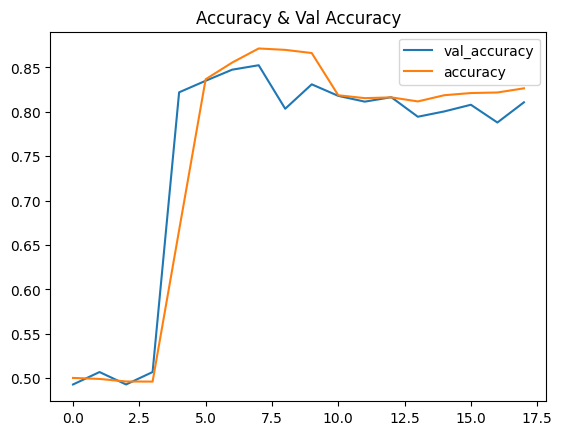

In [47]:
import matplotlib.pyplot as plt

print("evaluate model")
model_base.evaluate(pad_test,label_test,verbose=2,)

plt.plot(training.history['val_accuracy'])
plt.plot(training.history['accuracy'])
plt.legend(['val_accuracy','accuracy'])
plt.title('Accuracy & Val Accuracy')

In [60]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

test_sequence = tokenizer.texts_to_sequences(["pasrah aja soalnya gabisa login"])
padded_sentence =  pad_sequences(test_sequence,padding='post',maxlen=87)

# Prediksi dengan model
predictions = model_base.predict(padded_sentence)
# Tentukan treshold untuk setiap kategori

treshold_positif = 0.7
treshold_negatif = 0.32

print('prob : ',predictions[0])

# Klasifikasikan hasil berdasarkan treshold
if predictions[0] >= treshold_positif:
    hasil_klasifikasi = "positif"
elif predictions[0] <= treshold_negatif:
    hasil_klasifikasi = "negatif"
else:
    hasil_klasifikasi = "netral"

print('Kalimat Anda diprediksi sebagai ', hasil_klasifikasi)


1/1 [==============================] - 0s 17ms/step
prob :  [0.1807367]
Kalimat Anda diprediksi sebagai  negatif


In [63]:
model_base.save('model_sigmoid.h5')